In [3]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets
import torchvision.transforms as T
from torchvision.utils import make_grid, save_image

import time
from PIL import Image

from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

to_pil_image = T.ToPILImage()

GPU not available, CPU used


In [4]:
mnist_train = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=T.Compose([T.Resize(32), T.ToTensor(), T.Lambda(lambda x: torch.flatten(x))])
)

svhn_train = datasets.SVHN(
    root='data',
    download=True,
    split='train',
    transform=T.Compose([ T.ToTensor(), T.Lambda(lambda x: torch.flatten(x))])
)

Using downloaded and verified file: data/train_32x32.mat


In [5]:
svhn_train

Dataset SVHN
    Number of datapoints: 73257
    Root location: data
    Split: train
    StandardTransform
Transform: Compose(
               ToTensor()
               Lambda()
           )

# VAE

In [6]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size = 100, latent_size = 10):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, 2 * latent_size)
        )
    
    def sample(self, mu, sigma):
        eps = torch.randn_like(sigma)
        return mu + sigma * eps
        
    def forward(self, x):
        h = self.encoder(x)

        mu, log_var = torch.chunk(h, 2, dim=1)
        sigma = torch.exp(0.5*log_var) 
        z = self.sample(mu, sigma)
        
        return z, mu, sigma

class Decoder(nn.Module):
    def __init__(self, output_size, hidden_size = 100, latent_size = 10):
        super(Decoder, self).__init__()
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, output_size),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.decoder(x) 
    
class GaussianPrior(nn.Module):
    def __init__(self, latent_size=10):
        super(GaussianPrior, self).__init__()
        self.latent_size = latent_size

    def sample(self, batch_size):
        z = torch.randn((batch_size, self.latent_size))
        return z

    def log_prob(self, z):
        PI = torch.from_numpy(np.asarray(np.pi)).to(device)
        return -0.5 * torch.log(2. * PI) - 0.5 * z**2.
                

class VAE(nn.Module):
    def __init__(self, input_size, latent_size = 10, hidden_size = 100):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_size, latent_size = latent_size, hidden_size = hidden_size)
        self.decoder = Decoder(input_size, latent_size = latent_size, hidden_size = hidden_size)
        
    def forward(self, x):
        z, mu, sigma = self.encoder(x)
                
        return self.decoder(z), z, mu, sigma
    
    
class ELBO():
    def __init__(self, prior):
        self.prior = prior
        self.reconstruction_error = nn.BCELoss(reduction='none')
    
    def kullback_Leibler_divergence(self, z, mu, sigma):
        q = torch.distributions.Normal(mu, sigma)

        log_qz = q.log_prob(z)
        log_pz = self.prior.log_prob(z)
        
        kl = (log_qz - log_pz).sum(-1)
        
        return kl
    
    def __call__(self, inputs, outputs, z, mu, sigma):
        
        re = self.reconstruction_error(outputs, inputs).sum(-1)
        kl = self.kullback_Leibler_divergence(z, mu, sigma)

        elbo = (re + kl)
        return elbo.mean()

In [12]:

def train(net, prior, train_data, val_data, img_dim, batch_size=50, learning_rate=0.0001, epochs=20, nr_test_samples=64, img_dir='vae'):
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    criterion = ELBO(prior)
    
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)

    running_loss = []
    running_val_loss = []

    for epoch in range(epochs):
        print("Epoch:" , epoch+1)

        for i, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
            optimizer.zero_grad()

            inputs, _ = data
            inputs = inputs.to(device)

            # Forward
            outputs, z, mu, sigma = net(inputs)
            
            # Backward
            loss = criterion(inputs, outputs, z, mu, sigma)
            loss.backward()
            optimizer.step()
            
            running_loss.append(loss.item())
            
        sample = prior.sample(nr_test_samples)
        generated_img = net.decoder(sample).view(nr_test_samples,img_dim,32,32)
        generated_img = make_grid(generated_img)
    
        #SAVE IMAGE
        im = Image.fromarray(np.array(to_pil_image(generated_img)))
        im.save(f"Images_output/{img_dir}/epoch_{epoch}.jpeg")
        
        with torch.no_grad():
            for inputs, _ in val_loader:
                inputs = inputs.to(device)  
                outputs, z, mu, sigma  = net(inputs)
                loss = criterion(inputs, outputs, z, mu, sigma)
                running_val_loss.append(loss)
                
        print(f'Train Loss: {np.mean(running_loss[-len(train_data):])} | Validation Loss: {np.mean(running_val_loss[-len(val_data):])}')
    
    return running_loss, running_val_loss




## VAE on Mnist

In [13]:
vae_mnist = {}

input_size = 32*32
vae_mnist['net'] = VAE(input_size).to(device)
prior = GaussianPrior()
train_set, val_set = torch.utils.data.random_split(mnist_train, [55000, 5000])
vae_mnist['train_loss'], vae_mnist['val_loss'] = train(
    vae_mnist['net'],
    prior,
    train_set,
    val_set,
    1,
    epochs=50,
    img_dir='vae/mnist'
)


  1%|          | 10/1100 [00:00<00:11, 98.30it/s]

Epoch: 1


  1%|          | 13/1100 [00:00<00:08, 122.77it/s]

Train Loss: 319.2248721590909 | Validation Loss: 264.39910888671875
Epoch: 2


  1%|          | 13/1100 [00:00<00:08, 124.54it/s]

Train Loss: 287.23514415394175 | Validation Loss: 256.8773193359375
Epoch: 3


  1%|          | 13/1100 [00:00<00:08, 124.49it/s]

Train Loss: 269.08079359112367 | Validation Loss: 244.436767578125
Epoch: 4


  1%|          | 13/1100 [00:00<00:08, 124.70it/s]

Train Loss: 254.43384779496625 | Validation Loss: 234.91729736328125
Epoch: 5


  1%|          | 13/1100 [00:00<00:08, 125.44it/s]

Train Loss: 244.03397442072088 | Validation Loss: 227.9644317626953
Epoch: 6


  1%|          | 13/1100 [00:00<00:08, 121.41it/s]

Train Loss: 236.0909223544959 | Validation Loss: 222.39627075195312
Epoch: 7


  1%|          | 13/1100 [00:00<00:08, 124.40it/s]

Train Loss: 229.6192895329463 | Validation Loss: 217.60125732421875
Epoch: 8


  1%|          | 13/1100 [00:00<00:08, 125.48it/s]

Train Loss: 224.11923084605823 | Validation Loss: 213.47433471679688
Epoch: 9


  1%|          | 13/1100 [00:00<00:08, 124.75it/s]

Train Loss: 219.47527359008788 | Validation Loss: 209.96810913085938
Epoch: 10


  1%|          | 13/1100 [00:00<00:08, 125.34it/s]

Train Loss: 215.52261944302646 | Validation Loss: 206.9353790283203
Epoch: 11


  1%|          | 13/1100 [00:00<00:08, 124.78it/s]

Train Loss: 212.11048463553436 | Validation Loss: 204.29237365722656
Epoch: 12


  1%|          | 13/1100 [00:00<00:08, 124.32it/s]

Train Loss: 209.127319057349 | Validation Loss: 201.95289611816406
Epoch: 13


  1%|          | 13/1100 [00:00<00:08, 124.45it/s]

Train Loss: 206.49806086080056 | Validation Loss: 199.89353942871094
Epoch: 14


  1%|          | 13/1100 [00:00<00:08, 121.91it/s]

Train Loss: 204.1687996029544 | Validation Loss: 198.05799865722656
Epoch: 15


  1%|          | 13/1100 [00:00<00:08, 123.99it/s]

Train Loss: 202.08880984219638 | Validation Loss: 196.39805603027344
Epoch: 16


  1%|          | 13/1100 [00:00<00:08, 124.82it/s]

Train Loss: 200.21309693163093 | Validation Loss: 194.9000244140625
Epoch: 17


  1%|          | 13/1100 [00:00<00:08, 123.84it/s]

Train Loss: 198.51281676511712 | Validation Loss: 193.5304718017578
Epoch: 18


  1%|          | 12/1100 [00:00<00:09, 119.07it/s]

Train Loss: 196.96191137988157 | Validation Loss: 192.27188110351562
Epoch: 19


  1%|          | 13/1100 [00:00<00:08, 124.44it/s]

Train Loss: 195.5379074731854 | Validation Loss: 191.11680603027344
Epoch: 20


  1%|          | 13/1100 [00:00<00:08, 124.03it/s]

Train Loss: 194.22464346452193 | Validation Loss: 190.04476928710938
Epoch: 21


  1%|          | 13/1100 [00:00<00:08, 122.28it/s]

Train Loss: 193.010323140198 | Validation Loss: 189.0452423095703
Epoch: 22


  1%|          | 13/1100 [00:00<00:08, 123.88it/s]

Train Loss: 191.8795418283762 | Validation Loss: 188.11444091796875
Epoch: 23


  1%|          | 13/1100 [00:00<00:08, 125.20it/s]

Train Loss: 190.82542219018748 | Validation Loss: 187.23870849609375
Epoch: 24


  1%|          | 13/1100 [00:00<00:08, 122.37it/s]

Train Loss: 189.84004551511822 | Validation Loss: 186.4202117919922
Epoch: 25


  1%|          | 13/1100 [00:00<00:08, 122.89it/s]

Train Loss: 188.9158695994984 | Validation Loss: 185.65625
Epoch: 26


  1%|          | 13/1100 [00:00<00:08, 123.73it/s]

Train Loss: 188.0475212609351 | Validation Loss: 184.92849731445312
Epoch: 27


  1%|          | 13/1100 [00:00<00:08, 123.35it/s]

Train Loss: 187.22928637828892 | Validation Loss: 184.2415313720703
Epoch: 28


  1%|          | 13/1100 [00:00<00:08, 124.55it/s]

Train Loss: 186.45692745505988 | Validation Loss: 183.59234619140625
Epoch: 29


  1%|          | 13/1100 [00:00<00:08, 125.29it/s]

Train Loss: 185.7259947969921 | Validation Loss: 182.97804260253906
Epoch: 30


  1%|          | 13/1100 [00:00<00:08, 124.37it/s]

Train Loss: 185.03336758561568 | Validation Loss: 182.39332580566406
Epoch: 31


  1%|          | 13/1100 [00:00<00:08, 124.50it/s]

Train Loss: 184.37591410125106 | Validation Loss: 181.84300231933594
Epoch: 32


  1%|          | 13/1100 [00:00<00:08, 125.70it/s]

Train Loss: 183.7500720808723 | Validation Loss: 181.31332397460938
Epoch: 33


  1%|          | 13/1100 [00:00<00:08, 125.68it/s]

Train Loss: 183.1547504696176 | Validation Loss: 180.8097686767578
Epoch: 34


  1%|          | 13/1100 [00:00<00:08, 122.88it/s]

Train Loss: 182.58703192848571 | Validation Loss: 180.32586669921875
Epoch: 35


  1%|          | 13/1100 [00:00<00:08, 125.10it/s]

Train Loss: 182.04378577016854 | Validation Loss: 179.86810302734375
Epoch: 36


  1%|          | 13/1100 [00:00<00:08, 125.64it/s]

Train Loss: 181.52486592418015 | Validation Loss: 179.4279327392578
Epoch: 37


  1%|          | 13/1100 [00:00<00:08, 125.24it/s]

Train Loss: 181.02755698839042 | Validation Loss: 179.00344848632812
Epoch: 38


  1%|          | 13/1100 [00:00<00:08, 125.61it/s]

Train Loss: 180.551149861824 | Validation Loss: 178.5956573486328
Epoch: 39


  1%|          | 13/1100 [00:00<00:08, 122.67it/s]

Train Loss: 180.09439535216575 | Validation Loss: 178.20367431640625
Epoch: 40


  1%|          | 13/1100 [00:00<00:08, 125.13it/s]

Train Loss: 179.65456412679498 | Validation Loss: 177.82749938964844
Epoch: 41


  1%|          | 13/1100 [00:00<00:08, 124.67it/s]

Train Loss: 179.23126805612094 | Validation Loss: 177.46560668945312
Epoch: 42


  1%|          | 13/1100 [00:00<00:08, 125.48it/s]

Train Loss: 178.82469511750458 | Validation Loss: 177.11398315429688
Epoch: 43


  1%|          | 13/1100 [00:00<00:08, 124.90it/s]

Train Loss: 178.4320866313394 | Validation Loss: 176.77639770507812
Epoch: 44


  1%|          | 13/1100 [00:00<00:08, 124.71it/s]

Train Loss: 178.05357637452684 | Validation Loss: 176.45005798339844
Epoch: 45


  1%|          | 13/1100 [00:00<00:08, 124.84it/s]

Train Loss: 177.68840570931482 | Validation Loss: 176.1363067626953
Epoch: 46


  1%|          | 13/1100 [00:00<00:08, 125.97it/s]

Train Loss: 177.335193049314 | Validation Loss: 175.83184814453125
Epoch: 47


  1%|          | 13/1100 [00:00<00:08, 124.90it/s]

Train Loss: 176.99453203153334 | Validation Loss: 175.53985595703125
Epoch: 48


  1%|          | 13/1100 [00:00<00:08, 125.12it/s]

Train Loss: 176.66448967586865 | Validation Loss: 175.2528839111328
Epoch: 49


  1%|          | 13/1100 [00:00<00:08, 125.13it/s]

Train Loss: 176.34548578775437 | Validation Loss: 174.97474670410156
Epoch: 50


100%|██████████| 1100/1100 [00:08<00:00, 128.44it/s]


Train Loss: 176.03574458396218 | Validation Loss: 174.7064971923828


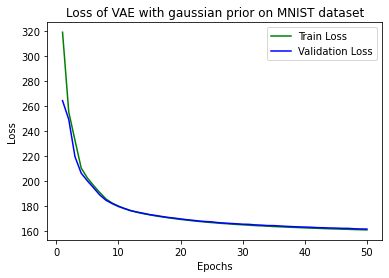

In [17]:
train_loss_epoch = np.array(vae_mnist['train_loss']).reshape(-1, int(55000/50)).mean(axis=1)
val_loss_epoch = np.array(vae_mnist['val_loss']).reshape(-1, int(5000/50)).mean(axis=1)

epochs_range = np.arange(1,51)
plt.plot(epochs_range, train_loss_epoch, 'g', label='Train Loss')
plt.plot(epochs_range, val_loss_epoch, 'b', label='Validation Loss')

#plt.plot(epochs_range, relu_acc, 'b', label='ReLU Accuracy')
plt.title('Loss of VAE with gaussian prior on MNIST dataset')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
def plot_manifold_sample(net, img_dim, n=12, l=10):
    w = 32
    img = np.zeros((n*w, n*w, img_dim))
    
    s, e1, e2 = prior.sample(3)
    
    for i, y in enumerate(np.linspace(0, 1, n)):
        for j, x in enumerate(np.linspace(0, 1, n)):
            
            z = s + (e1-s) * x + (e2-s) * y
            generated_image = net.decoder(z.view(-1,l)).view(img_dim, 32,32)

            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w,:] = generated_image.detach().numpy().transpose((1,2,0))
    plt.imshow(img, extent=[0, 1, 0, 1])


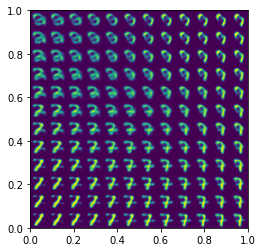

In [33]:
plot_manifold_sample(vae_mnist['net'], 1)

## VAE on svhn

In [36]:
input_size = 32*32*3

net_svhn = VAE(input_size).to(device)
train_set_svhn, val_set_svhn = torch.utils.data.random_split(svhn_train, [60000, 13257])
train_loss_svhn, val_loss_svhn = train(
    net_svhn,
    prior,
    train_set_svhn,
    val_set_svhn,
    3,
    epochs=50,
    img_dir='vae/svhn'
)


  1%|          | 7/1200 [00:00<00:17, 69.53it/s]

Epoch: 1


  1%|          | 8/1200 [00:00<00:15, 77.37it/s]

Train Loss: 2033.5243029785156 | Validation Loss: 1984.7652587890625
Epoch: 2


  1%|          | 8/1200 [00:00<00:15, 78.65it/s]

Train Loss: 2003.2337931315103 | Validation Loss: 1975.838134765625
Epoch: 3


  1%|          | 9/1200 [00:00<00:14, 80.44it/s]

Train Loss: 1988.4213657972548 | Validation Loss: 1968.0968017578125
Epoch: 4


  1%|          | 8/1200 [00:00<00:14, 79.86it/s]

Train Loss: 1977.8612259928386 | Validation Loss: 1961.891845703125
Epoch: 5


  1%|          | 9/1200 [00:00<00:14, 80.54it/s]

Train Loss: 1970.0945184733073 | Validation Loss: 1957.0274658203125
Epoch: 6


  1%|          | 9/1200 [00:00<00:14, 80.73it/s]

Train Loss: 1964.385679796007 | Validation Loss: 1953.62109375
Epoch: 7


  1%|          | 9/1200 [00:00<00:14, 80.96it/s]

Train Loss: 1960.16721929641 | Validation Loss: 1950.9619140625
Epoch: 8


  1%|          | 9/1200 [00:00<00:14, 80.50it/s]

Train Loss: 1956.8995382181804 | Validation Loss: 1948.9111328125
Epoch: 9


  1%|          | 9/1200 [00:00<00:14, 81.10it/s]

Train Loss: 1954.2855415287725 | Validation Loss: 1947.4041748046875
Epoch: 10


  1%|          | 9/1200 [00:00<00:14, 81.27it/s]

Train Loss: 1952.1394770100912 | Validation Loss: 1946.1002197265625
Epoch: 11


  1%|          | 9/1200 [00:00<00:14, 80.85it/s]

Train Loss: 1950.3293501882843 | Validation Loss: 1944.877685546875
Epoch: 12


  1%|          | 9/1200 [00:00<00:14, 80.69it/s]

Train Loss: 1948.697294837104 | Validation Loss: 1943.72412109375
Epoch: 13


  1%|          | 9/1200 [00:00<00:14, 81.19it/s]

Train Loss: 1947.2023692595653 | Validation Loss: 1942.611083984375
Epoch: 14


  1%|          | 9/1200 [00:00<00:14, 81.30it/s]

Train Loss: 1945.8133738708495 | Validation Loss: 1941.5120849609375
Epoch: 15


  1%|          | 9/1200 [00:00<00:14, 81.30it/s]

Train Loss: 1944.503217651367 | Validation Loss: 1940.5377197265625
Epoch: 16


  1%|          | 9/1200 [00:00<00:14, 80.61it/s]

Train Loss: 1943.3238880983988 | Validation Loss: 1939.6414794921875
Epoch: 17


  1%|          | 8/1200 [00:00<00:15, 76.30it/s]

Train Loss: 1942.26661856857 | Validation Loss: 1938.86376953125
Epoch: 18


  1%|          | 8/1200 [00:00<00:15, 79.38it/s]

Train Loss: 1941.3120135498048 | Validation Loss: 1938.13037109375
Epoch: 19


  1%|          | 8/1200 [00:00<00:15, 79.34it/s]

Train Loss: 1940.4420628597861 | Validation Loss: 1937.5146484375
Epoch: 20


  1%|          | 8/1200 [00:00<00:15, 78.58it/s]

Train Loss: 1939.5838934071858 | Validation Loss: 1936.852294921875
Epoch: 21


  1%|          | 8/1200 [00:00<00:14, 79.76it/s]

Train Loss: 1938.7755884612552 | Validation Loss: 1936.2216796875
Epoch: 22


  1%|          | 8/1200 [00:00<00:14, 79.72it/s]

Train Loss: 1938.0241479260994 | Validation Loss: 1935.635009765625
Epoch: 23


  1%|          | 8/1200 [00:00<00:15, 79.11it/s]

Train Loss: 1937.3306693477907 | Validation Loss: 1935.0869140625
Epoch: 24


  1%|          | 9/1200 [00:00<00:14, 80.30it/s]

Train Loss: 1936.6877891540528 | Validation Loss: 1934.5731201171875
Epoch: 25


  1%|          | 8/1200 [00:00<00:15, 78.63it/s]

Train Loss: 1936.0921817382812 | Validation Loss: 1934.0950927734375
Epoch: 26


  1%|          | 9/1200 [00:00<00:14, 80.88it/s]

Train Loss: 1935.5391403159117 | Validation Loss: 1933.67822265625
Epoch: 27


  1%|          | 9/1200 [00:00<00:14, 80.84it/s]

Train Loss: 1935.021603152428 | Validation Loss: 1933.26318359375
Epoch: 28


  1%|          | 9/1200 [00:00<00:14, 80.90it/s]

Train Loss: 1934.5380729094006 | Validation Loss: 1932.879150390625
Epoch: 29


  1%|          | 8/1200 [00:00<00:15, 75.71it/s]

Train Loss: 1934.0837914197198 | Validation Loss: 1932.524169921875
Epoch: 30


  1%|          | 8/1200 [00:00<00:15, 77.82it/s]

Train Loss: 1933.6495242173937 | Validation Loss: 1932.1712646484375
Epoch: 31


  1%|          | 8/1200 [00:00<00:15, 76.14it/s]

Train Loss: 1933.213542132634 | Validation Loss: 1931.818359375
Epoch: 32


  1%|          | 9/1200 [00:00<00:14, 80.45it/s]

Train Loss: 1932.795913921992 | Validation Loss: 1931.4866943359375
Epoch: 33


  1%|          | 9/1200 [00:00<00:14, 80.17it/s]

Train Loss: 1932.3985707076872 | Validation Loss: 1931.1588134765625
Epoch: 34


  1%|          | 9/1200 [00:00<00:14, 80.48it/s]

Train Loss: 1932.0209733013078 | Validation Loss: 1930.8531494140625
Epoch: 35


  1%|          | 8/1200 [00:00<00:14, 79.95it/s]

Train Loss: 1931.6600670485723 | Validation Loss: 1930.5654296875
Epoch: 36


  1%|          | 8/1200 [00:00<00:14, 79.58it/s]

Train Loss: 1931.3157199464022 | Validation Loss: 1930.285888671875
Epoch: 37


  1%|          | 9/1200 [00:00<00:14, 81.11it/s]

Train Loss: 1930.9881761898007 | Validation Loss: 1930.0213623046875
Epoch: 38


  1%|          | 8/1200 [00:00<00:15, 77.11it/s]

Train Loss: 1930.675810153359 | Validation Loss: 1929.765380859375
Epoch: 39


  1%|          | 8/1200 [00:00<00:14, 79.97it/s]

Train Loss: 1930.3779858294104 | Validation Loss: 1929.5191650390625
Epoch: 40


  1%|          | 8/1200 [00:00<00:15, 76.82it/s]

Train Loss: 1930.0930586547852 | Validation Loss: 1929.28125
Epoch: 41


  1%|          | 8/1200 [00:00<00:14, 79.83it/s]

Train Loss: 1929.8204392645612 | Validation Loss: 1929.0565185546875
Epoch: 42


  1%|          | 8/1200 [00:00<00:15, 76.69it/s]

Train Loss: 1929.5597555009147 | Validation Loss: 1928.8338623046875
Epoch: 43


  1%|          | 9/1200 [00:00<00:14, 80.68it/s]

Train Loss: 1929.3097358313273 | Validation Loss: 1928.630859375
Epoch: 44


  1%|          | 8/1200 [00:00<00:15, 77.65it/s]

Train Loss: 1929.0692852390173 | Validation Loss: 1928.4422607421875
Epoch: 45


  1%|          | 9/1200 [00:00<00:14, 80.55it/s]

Train Loss: 1928.83883114511 | Validation Loss: 1928.2679443359375
Epoch: 46


  1%|          | 8/1200 [00:00<00:15, 77.37it/s]

Train Loss: 1928.6167663972274 | Validation Loss: 1928.0775146484375
Epoch: 47


  1%|          | 9/1200 [00:00<00:14, 80.77it/s]

Train Loss: 1928.402636783681 | Validation Loss: 1927.8984375
Epoch: 48


  1%|          | 9/1200 [00:00<00:14, 80.82it/s]

Train Loss: 1928.1966811498007 | Validation Loss: 1927.7261962890625
Epoch: 49


  1%|          | 9/1200 [00:00<00:14, 80.93it/s]

Train Loss: 1927.9979347114822 | Validation Loss: 1927.5635986328125
Epoch: 50


100%|██████████| 1200/1200 [00:14<00:00, 81.58it/s]


Train Loss: 1927.8054746866862 | Validation Loss: 1927.2198486328125


In [37]:
vae_svhn = {}
vae_svhn['net'] = net_svhn
vae_svhn['train_loss'], vae_svhn['val_loss'] = train_loss_svhn, val_loss_svhn

In [ ]:
train_loss_epoch = np.array(vae_svhn['train_loss']).reshape(-1, int(60000/50)).mean(axis=1)
val_loss_epoch = np.array(vae_svhn['val_loss']).reshape(-1, int(13257/50) + 1).mean(axis=1)


epochs_range = np.arange(1,51)
plt.plot(epochs_range, train_loss_epoch, 'g', label='Train Loss')
plt.plot(epochs_range, val_loss_epoch, 'b', label='Validation Loss')

#plt.plot(epochs_range, relu_acc, 'b', label='ReLU Accuracy')
plt.title('Loss of VAE with gaussian prior on SVHN dataset')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
plot_manifold_sample(net_svhn, 3)

# VAE with flow based prior

In [38]:

# From https://github.com/jmtomczak/intro_dgm/blob/main/vaes/vae_priors_example.ipynb

class FlowPrior(nn.Module):
    def __init__(self, nets, nett, num_flows, D=2):
        super(FlowPrior, self).__init__()

        self.D = D

        self.t = torch.nn.ModuleList([nett() for _ in range(num_flows)])
        self.s = torch.nn.ModuleList([nets() for _ in range(num_flows)])
        self.num_flows = num_flows

    def coupling(self, x, index, forward=True):
        (xa, xb) = torch.chunk(x, 2, 1)

        s = self.s[index](xa)
        t = self.t[index](xa)

        if forward:
            #yb = f^{-1}(x)
            yb = (xb - t) * torch.exp(-s)
        else:
            #xb = f(y)
            yb = torch.exp(s) * xb + t

        return torch.cat((xa, yb), 1), s

    def permute(self, x):
        return x.flip(1)

    def f(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in range(self.num_flows):
            z, s = self.coupling(z, i, forward=True)
            z = self.permute(z)
            log_det_J = log_det_J - s.sum(dim=1)

        return z, log_det_J

    def f_inv(self, z):
        x = z
        for i in reversed(range(self.num_flows)):
            x = self.permute(x)
            x, _ = self.coupling(x, i, forward=False)

        return x

    def sample(self, batch_size):
        z = torch.randn(batch_size, self.D)
        x = self.f_inv(z)
        return x.view(-1, self.D)

    def log_prob(self, x):
        z, log_det_J = self.f(x)
        
        PI = torch.from_numpy(np.asarray(np.pi))
        log_standard_normal = -0.5 * torch.log(2. * PI) - 0.5 * z**2.
        
        log_p = (log_standard_normal + log_det_J.unsqueeze(1))
        return log_p

In [39]:
num_flows = 3
L = 10
M = 100

nets = lambda: nn.Sequential(nn.Linear(L // 2, M), nn.LeakyReLU(),
                            nn.Linear(M, M), nn.LeakyReLU(),
                            nn.Linear(M, L // 2), nn.Tanh())

nett = lambda: nn.Sequential(nn.Linear(L // 2, M), nn.LeakyReLU(),
                            nn.Linear(M, M), nn.LeakyReLU(),
                            nn.Linear(M, L // 2))

prior = FlowPrior(nets, nett, num_flows=num_flows, D=L)


# mnist
flow_mnist = {}


input_size = 32*32
flow_mnist['net'] = VAE(input_size).to(device)
train_set, val_set = torch.utils.data.random_split(mnist_train, [55000, 5000])
flow_mnist['train_loss'], flow_mnist['val_loss'] = train(
    flow_mnist['net'], prior, train_set,
    val_set, 1, epochs=50, img_dir='flow/mnist')




  1%|          | 8/1100 [00:00<00:14, 77.58it/s]

Epoch: 1


  1%|          | 10/1100 [00:00<00:11, 94.69it/s]

Train Loss: 311.97212237271395 | Validation Loss: 255.96922302246094
Epoch: 2


  1%|          | 10/1100 [00:00<00:11, 94.67it/s]

Train Loss: 278.99648092096504 | Validation Loss: 247.7375946044922
Epoch: 3


  1%|          | 9/1100 [00:00<00:12, 89.80it/s]

Train Loss: 261.468745283647 | Validation Loss: 236.14202880859375
Epoch: 4


  1%|          | 9/1100 [00:00<00:13, 81.17it/s]

Train Loss: 246.85224260850387 | Validation Loss: 226.65945434570312
Epoch: 5


  1%|          | 10/1100 [00:00<00:11, 93.82it/s]

Train Loss: 236.24290426913174 | Validation Loss: 219.5479278564453
Epoch: 6


  1%|          | 9/1100 [00:00<00:12, 85.34it/s]

Train Loss: 228.02229256601044 | Validation Loss: 213.77003479003906
Epoch: 7


  1%|          | 10/1100 [00:00<00:11, 93.62it/s]

Train Loss: 221.48422555700526 | Validation Loss: 209.13633728027344
Epoch: 8


  1%|          | 9/1100 [00:00<00:12, 87.20it/s]

Train Loss: 216.18280399495904 | Validation Loss: 205.27223205566406
Epoch: 9


  1%|          | 9/1100 [00:00<00:12, 88.15it/s]

Train Loss: 211.73320809874872 | Validation Loss: 201.9706268310547
Epoch: 10


  1%|          | 9/1100 [00:00<00:12, 87.94it/s]

Train Loss: 207.94452391607112 | Validation Loss: 199.12255859375
Epoch: 11


  1%|          | 9/1100 [00:00<00:12, 84.95it/s]

Train Loss: 204.65757466213762 | Validation Loss: 196.60565185546875
Epoch: 12


  1%|          | 9/1100 [00:00<00:12, 87.89it/s]

Train Loss: 201.77086528200093 | Validation Loss: 194.38406372070312
Epoch: 13


  1%|          | 10/1100 [00:00<00:12, 90.72it/s]

Train Loss: 199.2218846215735 | Validation Loss: 192.39822387695312
Epoch: 14


  1%|          | 10/1100 [00:00<00:11, 93.58it/s]

Train Loss: 196.9564790889195 | Validation Loss: 190.61814880371094
Epoch: 15


  1%|          | 10/1100 [00:00<00:12, 90.52it/s]

Train Loss: 194.92661050322562 | Validation Loss: 189.02157592773438
Epoch: 16


  1%|          | 10/1100 [00:00<00:11, 91.26it/s]

Train Loss: 193.09444750092246 | Validation Loss: 187.5651397705078
Epoch: 17


  1%|          | 9/1100 [00:00<00:12, 85.15it/s]

Train Loss: 191.43209882766806 | Validation Loss: 186.2414093017578
Epoch: 18


  1%|          | 9/1100 [00:00<00:12, 88.07it/s]

Train Loss: 189.913925496111 | Validation Loss: 185.02667236328125
Epoch: 19


  1%|          | 10/1100 [00:00<00:11, 92.93it/s]

Train Loss: 188.51931999389063 | Validation Loss: 183.9051971435547
Epoch: 20


  1%|          | 10/1100 [00:00<00:11, 91.43it/s]

Train Loss: 187.23066203724255 | Validation Loss: 182.86489868164062
Epoch: 21


  1%|          | 10/1100 [00:00<00:11, 92.97it/s]

Train Loss: 186.0372612792176 | Validation Loss: 181.892822265625
Epoch: 22


  1%|          | 10/1100 [00:00<00:11, 93.70it/s]

Train Loss: 184.92685202606452 | Validation Loss: 180.9853057861328
Epoch: 23


  1%|          | 10/1100 [00:00<00:11, 93.57it/s]

Train Loss: 183.88964068446705 | Validation Loss: 180.1345977783203
Epoch: 24


  1%|          | 10/1100 [00:00<00:11, 91.34it/s]

Train Loss: 182.91829861669828 | Validation Loss: 179.33489990234375
Epoch: 25


  1%|          | 10/1100 [00:00<00:11, 93.19it/s]

Train Loss: 182.00515393343838 | Validation Loss: 178.58322143554688
Epoch: 26


  1%|          | 10/1100 [00:00<00:11, 93.68it/s]

Train Loss: 181.1449896229564 | Validation Loss: 177.87033081054688
Epoch: 27


  1%|          | 10/1100 [00:00<00:11, 93.71it/s]

Train Loss: 180.33333164150866 | Validation Loss: 177.19265747070312
Epoch: 28


  1%|          | 10/1100 [00:00<00:11, 94.02it/s]

Train Loss: 179.56515902283903 | Validation Loss: 176.5494842529297
Epoch: 29


  1%|          | 10/1100 [00:00<00:11, 93.67it/s]

Train Loss: 178.8365998271117 | Validation Loss: 175.9429931640625
Epoch: 30


  1%|          | 10/1100 [00:00<00:11, 93.53it/s]

Train Loss: 178.14484413424404 | Validation Loss: 175.36045837402344
Epoch: 31


  1%|          | 10/1100 [00:00<00:11, 93.60it/s]

Train Loss: 177.4877384971104 | Validation Loss: 174.80909729003906
Epoch: 32


  1%|          | 10/1100 [00:00<00:11, 91.05it/s]

Train Loss: 176.86146263122558 | Validation Loss: 174.2818145751953
Epoch: 33


  1%|          | 10/1100 [00:00<00:11, 93.90it/s]

Train Loss: 176.26448350764502 | Validation Loss: 173.77857971191406
Epoch: 34


  1%|          | 10/1100 [00:00<00:11, 93.53it/s]

Train Loss: 175.69474164299785 | Validation Loss: 173.30062866210938
Epoch: 35


  1%|          | 10/1100 [00:00<00:11, 93.61it/s]

Train Loss: 175.15007450648716 | Validation Loss: 172.83599853515625
Epoch: 36


  1%|          | 10/1100 [00:00<00:11, 94.26it/s]

Train Loss: 174.62775250675702 | Validation Loss: 172.39137268066406
Epoch: 37


  1%|          | 10/1100 [00:00<00:11, 92.34it/s]

Train Loss: 174.12734355504742 | Validation Loss: 171.9654998779297
Epoch: 38


  1%|          | 10/1100 [00:00<00:11, 93.86it/s]

Train Loss: 173.6470504187625 | Validation Loss: 171.55970764160156
Epoch: 39


  1%|          | 10/1100 [00:00<00:11, 93.99it/s]

Train Loss: 173.1860725897231 | Validation Loss: 171.16624450683594
Epoch: 40


  1%|          | 10/1100 [00:00<00:11, 93.72it/s]

Train Loss: 172.7428999703147 | Validation Loss: 170.78631591796875
Epoch: 41


  1%|          | 9/1100 [00:00<00:12, 89.87it/s]

Train Loss: 172.31580416525017 | Validation Loss: 170.42092895507812
Epoch: 42


  1%|          | 10/1100 [00:00<00:12, 90.57it/s]

Train Loss: 171.904231243051 | Validation Loss: 170.06961059570312
Epoch: 43


  1%|          | 10/1100 [00:00<00:12, 90.83it/s]

Train Loss: 171.5079728750346 | Validation Loss: 169.72999572753906
Epoch: 44


  1%|          | 10/1100 [00:00<00:11, 91.66it/s]

Train Loss: 171.1255919672438 | Validation Loss: 169.40304565429688
Epoch: 45


  1%|          | 10/1100 [00:00<00:11, 92.46it/s]

Train Loss: 170.75597077309965 | Validation Loss: 169.08644104003906
Epoch: 46


  1%|          | 10/1100 [00:00<00:11, 92.79it/s]

Train Loss: 170.39935924122926 | Validation Loss: 168.77882385253906
Epoch: 47


  1%|          | 10/1100 [00:00<00:11, 92.71it/s]

Train Loss: 170.05426504817646 | Validation Loss: 168.48175048828125
Epoch: 48


  1%|          | 10/1100 [00:00<00:11, 92.07it/s]

Train Loss: 169.72075495228623 | Validation Loss: 168.19354248046875
Epoch: 49


  1%|          | 10/1100 [00:00<00:11, 92.29it/s]

Train Loss: 169.39748370197134 | Validation Loss: 167.91444396972656
Epoch: 50


100%|██████████| 1100/1100 [00:11<00:00, 94.94it/s]


Train Loss: 169.08385332253195 | Validation Loss: 167.64218139648438


In [40]:
#svhn
flow_svhn = {}

input_size = 32*32*3
prior = FlowPrior(nets, nett, num_flows=num_flows, D=L)


flow_svhn['net'] = VAE(input_size).to(device)
train_set, val_set = torch.utils.data.random_split(svhn_train, [60000, 13257])
flow_svhn['train_loss'], flow_svhn['val_loss'] = train(
    flow_svhn['net'], prior, train_set,
    val_set, 3, epochs=50, img_dir='flow/svhn')



  0%|          | 6/1200 [00:00<00:20, 58.45it/s]

Epoch: 1


  1%|          | 7/1200 [00:00<00:18, 64.90it/s]

Train Loss: 2021.4985541788737 | Validation Loss: 1982.4224853515625
Epoch: 2


  1%|          | 7/1200 [00:00<00:18, 65.38it/s]

Train Loss: 1995.0074867248536 | Validation Loss: 1968.66943359375
Epoch: 3


  1%|          | 7/1200 [00:00<00:18, 63.87it/s]

Train Loss: 1980.1493119303386 | Validation Loss: 1960.4373779296875
Epoch: 4


  1%|          | 7/1200 [00:00<00:18, 64.33it/s]

Train Loss: 1970.7626906077066 | Validation Loss: 1955.6412353515625
Epoch: 5


  1%|          | 7/1200 [00:00<00:18, 65.07it/s]

Train Loss: 1964.4196631266277 | Validation Loss: 1951.8841552734375
Epoch: 6


  1%|          | 7/1200 [00:00<00:18, 64.42it/s]

Train Loss: 1959.6796940612794 | Validation Loss: 1949.144287109375
Epoch: 7


  1%|          | 7/1200 [00:00<00:18, 65.03it/s]

Train Loss: 1956.128828517369 | Validation Loss: 1947.065673828125
Epoch: 8


  1%|          | 7/1200 [00:00<00:18, 64.73it/s]

Train Loss: 1953.365558420817 | Validation Loss: 1945.401611328125
Epoch: 9


  1%|          | 7/1200 [00:00<00:18, 65.00it/s]

Train Loss: 1951.1430222913955 | Validation Loss: 1944.0037841796875
Epoch: 10


  1%|          | 7/1200 [00:00<00:18, 64.55it/s]

Train Loss: 1949.3050625712076 | Validation Loss: 1942.8116455078125
Epoch: 11


  1%|          | 7/1200 [00:00<00:18, 64.39it/s]

Train Loss: 1947.6420320545544 | Validation Loss: 1941.639892578125
Epoch: 12


  1%|          | 7/1200 [00:00<00:18, 64.40it/s]

Train Loss: 1946.144945203993 | Validation Loss: 1940.6260986328125
Epoch: 13


  1%|          | 7/1200 [00:00<00:18, 63.53it/s]

Train Loss: 1944.8367779228015 | Validation Loss: 1939.7674560546875
Epoch: 14


  1%|          | 7/1200 [00:00<00:18, 64.86it/s]

Train Loss: 1943.6945432608468 | Validation Loss: 1939.01806640625
Epoch: 15


  1%|          | 7/1200 [00:00<00:18, 63.73it/s]

Train Loss: 1942.6897557169596 | Validation Loss: 1938.329833984375
Epoch: 16


  1%|          | 7/1200 [00:00<00:18, 64.29it/s]

Train Loss: 1941.794869594574 | Validation Loss: 1937.7027587890625
Epoch: 17


  1%|          | 7/1200 [00:00<00:18, 64.62it/s]

Train Loss: 1940.9582104192996 | Validation Loss: 1937.081787109375
Epoch: 18


  1%|          | 7/1200 [00:00<00:18, 64.35it/s]

Train Loss: 1940.1644270437735 | Validation Loss: 1936.4920654296875
Epoch: 19


  1%|          | 7/1200 [00:00<00:18, 65.15it/s]

Train Loss: 1939.436801939847 | Validation Loss: 1935.9525146484375
Epoch: 20


  1%|          | 7/1200 [00:00<00:18, 65.10it/s]

Train Loss: 1938.769936650594 | Validation Loss: 1935.461669921875
Epoch: 21


  1%|          | 7/1200 [00:00<00:18, 64.63it/s]

Train Loss: 1938.1445591614738 | Validation Loss: 1934.974609375
Epoch: 22


  1%|          | 7/1200 [00:00<00:18, 65.18it/s]

Train Loss: 1937.50838120894 | Validation Loss: 1934.46337890625
Epoch: 23


  1%|          | 7/1200 [00:00<00:18, 65.72it/s]

Train Loss: 1936.9051042462777 | Validation Loss: 1933.983642578125
Epoch: 24


  1%|          | 7/1200 [00:00<00:18, 64.47it/s]

Train Loss: 1936.3445742543538 | Validation Loss: 1933.55419921875
Epoch: 25


  1%|          | 7/1200 [00:00<00:18, 65.34it/s]

Train Loss: 1935.8206847371418 | Validation Loss: 1933.133056640625
Epoch: 26


  1%|          | 7/1200 [00:00<00:18, 65.88it/s]

Train Loss: 1935.3299876755934 | Validation Loss: 1932.7469482421875
Epoch: 27


  1%|          | 7/1200 [00:00<00:18, 65.53it/s]

Train Loss: 1934.8606581473646 | Validation Loss: 1932.3414306640625
Epoch: 28


  1%|          | 7/1200 [00:00<00:18, 64.95it/s]

Train Loss: 1934.386571539016 | Validation Loss: 1931.9462890625
Epoch: 29


  1%|          | 7/1200 [00:00<00:18, 66.10it/s]

Train Loss: 1933.9237014419732 | Validation Loss: 1931.56982421875
Epoch: 30


  1%|          | 7/1200 [00:00<00:18, 65.74it/s]

Train Loss: 1933.4842227783204 | Validation Loss: 1931.21044921875
Epoch: 31


  1%|          | 7/1200 [00:00<00:18, 63.82it/s]

Train Loss: 1933.0704656949608 | Validation Loss: 1930.8731689453125
Epoch: 32


  1%|          | 7/1200 [00:00<00:18, 65.99it/s]

Train Loss: 1932.6781068929035 | Validation Loss: 1930.5538330078125
Epoch: 33


  1%|          | 7/1200 [00:00<00:17, 66.30it/s]

Train Loss: 1932.3074847874498 | Validation Loss: 1930.2442626953125
Epoch: 34


  1%|          | 7/1200 [00:00<00:18, 65.65it/s]

Train Loss: 1931.9556788216385 | Validation Loss: 1929.9444580078125
Epoch: 35


  1%|          | 7/1200 [00:00<00:18, 65.95it/s]

Train Loss: 1931.6215662405832 | Validation Loss: 1929.6680908203125
Epoch: 36


  1%|          | 7/1200 [00:00<00:17, 66.37it/s]

Train Loss: 1931.3037504916722 | Validation Loss: 1929.40283203125
Epoch: 37


  1%|          | 7/1200 [00:00<00:18, 66.13it/s]

Train Loss: 1931.0018494394662 | Validation Loss: 1929.158935546875
Epoch: 38


  1%|          | 7/1200 [00:00<00:18, 66.08it/s]

Train Loss: 1930.71367244252 | Validation Loss: 1928.9356689453125
Epoch: 39


  1%|          | 7/1200 [00:00<00:17, 66.43it/s]

Train Loss: 1930.4390285289796 | Validation Loss: 1928.7098388671875
Epoch: 40


  1%|          | 7/1200 [00:00<00:18, 65.92it/s]

Train Loss: 1930.176422976176 | Validation Loss: 1928.4774169921875
Epoch: 41


  1%|          | 7/1200 [00:00<00:18, 66.24it/s]

Train Loss: 1929.9229638250088 | Validation Loss: 1928.265869140625
Epoch: 42


  1%|          | 7/1200 [00:00<00:18, 65.91it/s]

Train Loss: 1929.668158324711 | Validation Loss: 1928.04296875
Epoch: 43


  1%|          | 7/1200 [00:00<00:18, 63.28it/s]

Train Loss: 1929.4085704359898 | Validation Loss: 1927.8228759765625
Epoch: 44


  1%|          | 7/1200 [00:00<00:18, 63.25it/s]

Train Loss: 1929.1568831865716 | Validation Loss: 1927.6102294921875
Epoch: 45


  1%|          | 7/1200 [00:00<00:18, 65.92it/s]

Train Loss: 1928.9143568318684 | Validation Loss: 1927.4053955078125
Epoch: 46


  1%|          | 7/1200 [00:00<00:19, 62.72it/s]

Train Loss: 1928.6813420392466 | Validation Loss: 1927.200927734375
Epoch: 47


  1%|          | 7/1200 [00:00<00:18, 66.05it/s]

Train Loss: 1928.457062975295 | Validation Loss: 1927.01171875
Epoch: 48


  1%|          | 7/1200 [00:00<00:18, 64.91it/s]

Train Loss: 1928.2407865651448 | Validation Loss: 1926.82861328125
Epoch: 49


  1%|          | 7/1200 [00:00<00:18, 64.85it/s]

Train Loss: 1928.0324762481896 | Validation Loss: 1926.6500244140625
Epoch: 50


100%|██████████| 1200/1200 [00:19<00:00, 62.94it/s]


Train Loss: 1927.8321285847983 | Validation Loss: 1926.29736328125


# FID Score

In [480]:
mnist_test = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=T.Compose([T.Resize(32), T.ToTensor()])
)
mnist_test_tensor_flat = torch.stack([torch.flatten(i[0]) for i in mnist_test])

svhn_test = datasets.SVHN(
    root='data',
    split='test',
    download=True,
    transform=T.Compose([ T.ToTensor(), T.Lambda(lambda x: torch.flatten(x))])
)

svhn_test_tensor = torch.stack([i[0] for i in svhn_test])



Using downloaded and verified file: data/test_32x32.mat


In [491]:
mnist_vae_generated_images,_,_,_ = vae_mnist['net'](mnist_test_tensor_flat)
mnist_vae_generated_images = mnist_vae_generated_images.view(-1,1,32,32).repeat(1,3,1,1)
mnist_real_images = mnist_test_tensor_flat.view(-1,1,32,32).repeat(1,3,1,1)

In [ ]:
score = calculate_frechet(mnist_vae_generated_images,mnist_real_images,inception_model)

In [2]:
score

NameError: name 'score' is not defined

In [486]:
import torchvision.models as models

class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps
        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)
        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp

block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
inception_model = InceptionV3([block_idx])

In [467]:
def calculate_activation_statistics(images,model,batch_size=128, dims=2048,
                    cuda=False):
    model.eval()
    act=np.empty((len(images), dims))
    
    batch=images
    pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

In [468]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [469]:
def calculate_frechet(images_real,images_fake,model):
    mu_1,std_1=calculate_activation_statistics(images_real,model,cuda=True)
    mu_2,std_2=calculate_activation_statistics(images_fake,model,cuda=True)

    fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
    return fid_value